In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10
from torchvision import transforms as tv
from torchvision.models import ResNet
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from cond_resnet import cond_resnet18, CondResnet, FC_FOR_CHANNELS, MAIN_FC_KS
import numpy as np
import matplotlib.pyplot as plt
from resnet import resnet18
import pandas as pd
import altair as alt
from PIL import Image

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
ds = CIFAR10('data/c10', train=True, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a tensor
ds_test = CIFAR10('data/c10', train=False, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a t

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size=64

train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)

In [6]:
def train_step_regular(
    X, y, net, opt, loss_fn
) -> float:
    opt.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    opt.step()
    return loss.item()

def train_step_cond_one_head(
    X, y, net, opt, loss_fn,
    max_k: int = 64,
    n_samples = 10
):
    opt.zero_grad()
    samples = np.arange(1, max_k)
    np.random.shuffle(samples)
    samples = samples[:n_samples]
    samples = list(samples) + [max_k] 
    loss = 0
    _, inter = net(X, return_intermediate=True, main_fc_ks=samples)
    
    for k, y_pred in inter[MAIN_FC_KS].items():
        loss += loss_fn(y_pred, y)
        
    loss.backward()
    opt.step()
    return loss.item()

def train_step_cond_multiple_heads(
    X, y, net, opt, loss_fn,
    max_k: int = 64,
):
    opt.zero_grad()
    _, inter = net(X, return_intermediate=True)
    loss = 0
    for k, y_pred in inter[FC_FOR_CHANNELS].items():
        loss += loss_fn(y_pred, y)
        
    loss.backward()
    opt.step()
    return loss.item()

def val_metrics(dl, net, loss_fn, k=None, eval_on_specific_head: bool = False):
    val_losses = []
    y_predicted = []
    y_true = []

    with torch.no_grad():
        for iteration, (X_val, y_val) in enumerate(dl):

            X_val, y_val = [t.to(device) for t in [X_val, y_val]]
            
            if isinstance(net, CondResnet):
                assert isinstance(k, int)
                y_pred, inter = net(X_val, full_k=k, return_intermediate=True)

                if eval_on_specific_head:
                    y_pred= inter[FC_FOR_CHANNELS][k]
                    
            elif isinstance(net, ResNet):
                y_pred = net(X_val)
            loss = loss_fn(y_pred, y_val)
            val_losses.append(loss.item())
            y_pred = y_pred.argmax(dim=1)
            y_true.extend(y_val.cpu().numpy())
            y_predicted.extend(y_pred.cpu().numpy())

        val_acc = accuracy_score(y_true, y_predicted)
    return val_acc, np.mean(val_losses)

def train_net(net, number_of_epochs = 10, eval_channels = None, step_fn = None, eval_on_specific_head: bool = False):
    
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters())
    
    metrics_list = []
    for i in range(number_of_epochs):
        train_loss = 0
        for iteration, (X_train, y_train) in enumerate(train_dl):
            
            X_train, y_train = [t.to(device) for t in [X_train, y_train]]

            if isinstance(net, CondResnet):
                loss_step = step_fn(X_train, y_train, net, opt, loss_fn)
            elif isinstance(net, ResNet):
                loss_step = train_step_regular(X_train, y_train, net, opt, loss_fn)

        
            
        if isinstance(net, CondResnet):
            metrics = dict()
            for k in eval_channels:
                train_acc, train_loss = val_metrics(train_dl, net, loss_fn, k=k, eval_on_specific_head=eval_on_specific_head)
                val_acc, val_loss = val_metrics(valid_dl, net, loss_fn, k=k, eval_on_specific_head=eval_on_specific_head)
                metrics[k] = {
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc
                }
        elif isinstance(net, ResNet):
            train_acc, train_loss = val_metrics(train_dl, net, loss_fn)
            val_acc, val_loss = val_metrics(valid_dl, net, loss_fn)
            metrics = {net.inplanes // 8: {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            }}

        print(f'#Epoch: {i}, metrics: {metrics}')
        metrics_list.append(metrics)
    return metrics_list

In [7]:
def plot_metrics(ml, show_train: bool = False):
    channels = ml[0].keys()
    fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    
    
    folds_markers = {
        "val": "o"
    }
    if show_train:
        folds_markers["train"] = "^"
    for c in sorted(channels):
        
        alpha = (c+30) / (64+30)
        for fold, marker in folds_markers.items():
            mn = f"{fold}_loss"
            ax[0].plot(list(range(len(ml))), [m[c][mn] for m in ml], label=f"{mn} @ {c}", marker=marker, alpha=alpha)
        
        for fold, marker in folds_markers.items():
            mn = f"{fold}_acc"
            ax[1].plot(list(range(len(ml))), [m[c][mn] for m in ml], label=f"{mn} @ {c}", marker=marker, alpha=alpha)
        
    [
        a.legend(
            loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5    
        ) 
    for a in ax]
    [a.grid() for a in ax]
    ax[1].set_ylim(0,1)


### Training a classical resnet with different initial featuremap channels (the default is 64)

In [8]:
NUM_EPOCHS = 50

EVAL_CHANNELS =  sorted(list(set(range(1, 64, 8))) + [64])
EVAL_CHANNELS

[1, 9, 17, 25, 33, 41, 49, 57, 64]

In [ ]:
m_r18 = [dict() for _ in range(10)]

for k in EVAL_CHANNELS:
    print("training classic for", k)
    r18 = resnet18(in_planes=k)
    ms = train_net(r18, NUM_EPOCHS)
    for m1, m2 in zip(m_r18, ms):
        m1.update(m2)

training classic for 1
#Epoch: 0, metrics: {1: {'train_loss': 2.1907894422331124, 'train_acc': 0.1793, 'val_loss': 2.1887520012582184, 'val_acc': 0.18}}
#Epoch: 1, metrics: {1: {'train_loss': 2.0470988119349762, 'train_acc': 0.22884, 'val_loss': 2.0419898891145256, 'val_acc': 0.2352}}
#Epoch: 2, metrics: {1: {'train_loss': 1.9940656704061173, 'train_acc': 0.24414, 'val_loss': 1.9886297397552781, 'val_acc': 0.2488}}
#Epoch: 3, metrics: {1: {'train_loss': 1.9493328584429552, 'train_acc': 0.26972, 'val_loss': 1.9461005075721984, 'val_acc': 0.2708}}
#Epoch: 4, metrics: {1: {'train_loss': 1.9148159440216201, 'train_acc': 0.27792, 'val_loss': 1.9123665648660841, 'val_acc': 0.2755}}
#Epoch: 5, metrics: {1: {'train_loss': 1.884145667028549, 'train_acc': 0.28716, 'val_loss': 1.8861834615658803, 'val_acc': 0.2892}}
#Epoch: 6, metrics: {1: {'train_loss': 1.8491921392852997, 'train_acc': 0.3064, 'val_loss': 1.8499636338774565, 'val_acc': 0.299}}
#Epoch: 7, metrics: {1: {'train_loss': 1.82463978349

Text(0.5, 0.98, 'Classic resnet')

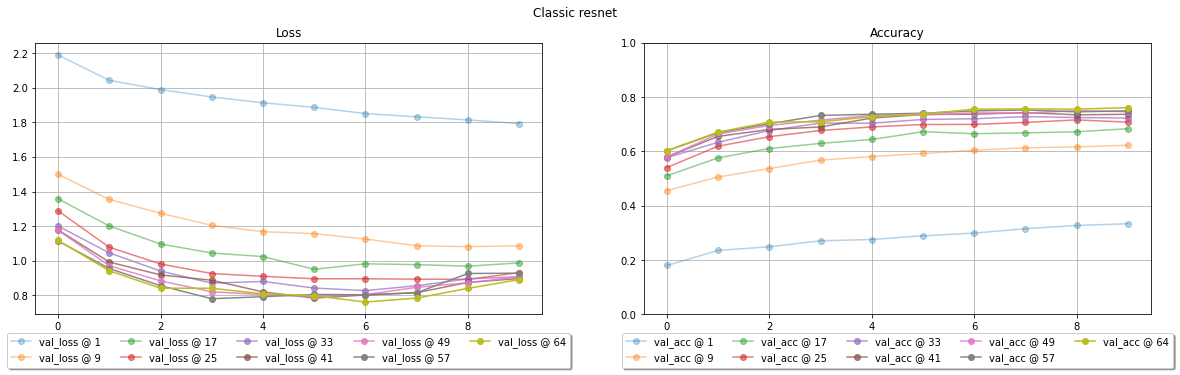

In [18]:
plot_metrics(m_r18)
plt.suptitle("Classic resnet")

### Training a single conditional Resnet and evaulating it with different $k$ numbers of channels

In [ ]:
cond_r18_one = cond_resnet18()
m_cr18_one = train_net(cond_r18_one, NUM_EPOCHS, eval_channels=EVAL_CHANNELS, step_fn=train_step_cond_one_head, eval_on_specific_head=False)


Text(0.5, 0.98, 'Conditional resnet, one head')

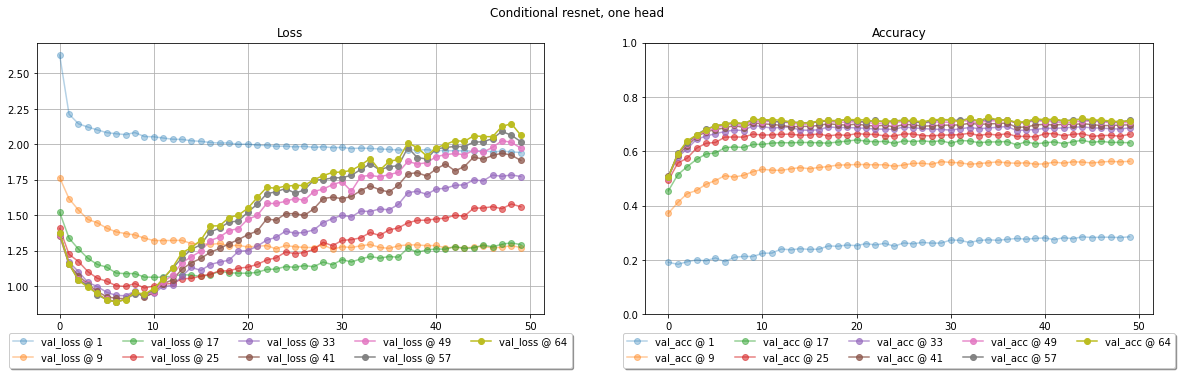

In [19]:
plot_metrics(m_cr18_one)
plt.suptitle("Conditional resnet, one head")

In [ ]:

cond_r18_multi = cond_resnet18(fc_for_channels=EVAL_CHANNELS)
m_cr18_multi = train_net(cond_r18_multi, NUM_EPOCHS, eval_channels=EVAL_CHANNELS, step_fn=train_step_cond_multiple_heads, eval_on_specific_head=True)


Text(0.5, 0.98, 'Conditional resnet, multiple heads')

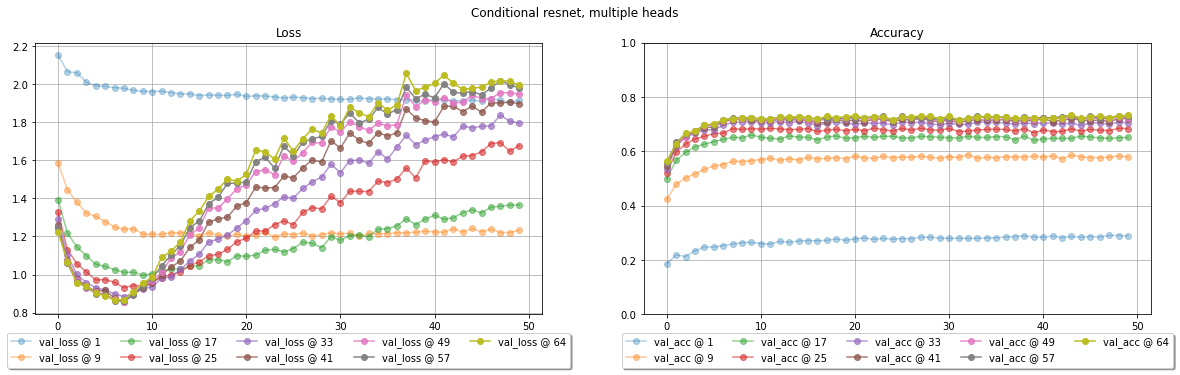

In [20]:
plot_metrics(m_cr18_multi)
plt.suptitle("Conditional resnet, multiple heads")

In [24]:
rows = []

for (model, epochs) in [
    ("resnet", m_r18),
    ("cond_resnet_one_head", m_cr18_one),
    ("cond_resnet_multi_head", m_cr18_multi)
]:
    for epoch, channel_to_metrics in enumerate(epochs):
        for channel, metrics in channel_to_metrics.items():
            for m, v in metrics.items():
                fold, metric = m.split("_")
                rows.append({
                    "model": model,
                    "epoch": epoch,
                    "channel": channel,
                    "fold": fold,
                    "metric": metric,
                    "value": v
                })

df = pd.DataFrame(rows)
df.to_csv("metrics.csv")
# df

df[df.epoch==9][df.fold=="val"][df.metric=="acc"]

/tmp/ipykernel_3155702/3065965286.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.epoch==9][df.fold=="val"][df.metric=="acc"]


,model,epoch,channel,fold,metric,value
327,resnet,9,1,val,acc,0.3336
331,resnet,9,9,val,acc,0.6223
335,resnet,9,17,val,acc,0.6831
339,resnet,9,25,val,acc,0.7074
343,resnet,9,33,val,acc,0.7224
347,resnet,9,41,val,acc,0.7362
351,resnet,9,49,val,acc,0.7459
355,resnet,9,57,val,acc,0.7489
359,resnet,9,64,val,acc,0.7606
687,cond_resnet_one_head,9,1,val,acc,0.2128


*Something* is training, but the conditional resnet with $k$ channels is not as efficient as a resnet explicitly trained to use $k$ channels.

/tmp/ipykernel_3155702/3639980888.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subdf= df[df.epoch==9][df.fold=="val"][df.metric=="acc"][df.model==model]
/tmp/ipykernel_3155702/3639980888.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subdf= df[df.epoch==9][df.fold=="val"][df.metric=="acc"][df.model==model]
/tmp/ipykernel_3155702/3639980888.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subdf= df[df.epoch==9][df.fold=="val"][df.metric=="acc"][df.model==model]


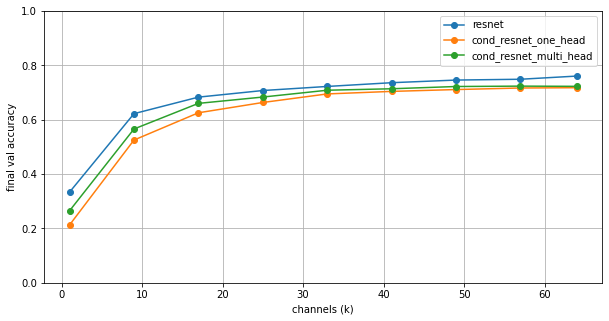

In [23]:
plt.figure(figsize=(10, 5))

for model in df.model.unique():
    subdf= df[df.epoch==9][df.fold=="val"][df.metric=="acc"][df.model==model]
    plt.plot(subdf.channel, subdf.value, label=model, marker="o")

plt.xlabel("channels (k)")
plt.ylabel("final val accuracy")
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()